In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

## データの分析

In [17]:
# volume(出来高)を整数に変換する
def convert_volume(volume):
    if isinstance(volume, str):
        if 'B' in volume:
            return int(float(volume.replace('B', '')) * 1e9)
        elif 'M' in volume:
            return int(float(volume.replace('M', '')) * 1e6)
        elif 'K' in volume:
            return int(float(volume.replace('K', '')) * 1e3)
    return int(volume)

# データの読み込みと軸の設定
df = pd.read_csv('stock_price.csv', index_col='日付け', parse_dates=True)
axis = ['close', 'open', 'high', 'low', 'volume', 'rate']
df.columns = axis
df.index.name = 'date'
df = df.sort_index()
df['volume'] = df['volume'].apply(convert_volume)
df.head()

,close,open,high,low,volume,rate
date,,,,,,
1987-02-12,182.4,182.4,182.4,182.4,1280000000,16.25%
1987-02-13,172.5,176.5,176.5,172.5,422380000,-5.43%
1987-02-16,175.5,166.7,175.5,165.7,360510000,1.74%
1987-02-17,182.4,176.5,184.3,175.5,881510000,3.93%
1987-02-18,191.2,186.3,191.2,186.3,795090000,4.82%


### キャンドル図

c:\Users\nabem\AppData\Local\Programs\Python\Python312\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


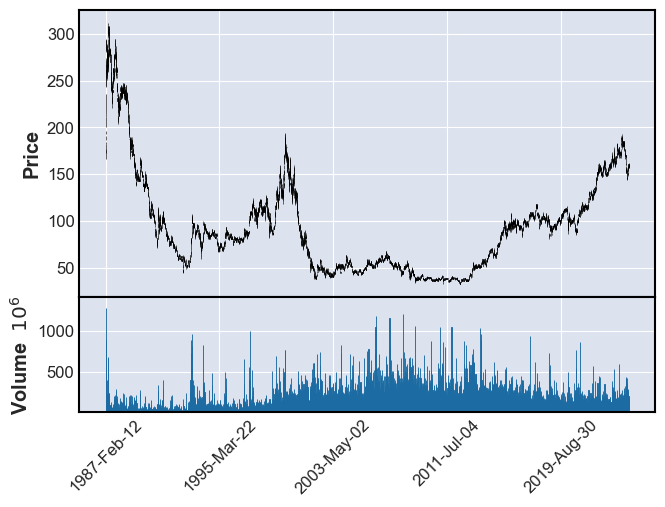

In [18]:
mpf.plot(df, type='candle', volume=True)

終値(close)単体では法則性のようなものは見られない。また出来高(volume)との関連は一見見ただけでは明確ではないが、隠れた関係性がある可能性も純分に考えなければならない。

### 基本統計量の確認

In [19]:
df.describe()

,close,open,high,low,volume
count,9202.000000,9202.000000,9202.000000,9202.000000,9.202000e+03
mean,92.180961,92.256183,93.176451,91.330146,1.726677e+08
std,50.452228,50.598215,51.049837,50.087405,1.251280e+08
min,33.000000,33.000000,33.200000,32.200000,9.340000e+06
25%,52.000000,52.100000,52.800000,51.500000,8.073000e+07
50%,85.100000,85.100000,86.050000,84.200000,1.540150e+08
75%,110.800000,110.800000,111.900000,109.275000,2.305225e+08
max,305.900000,309.800000,311.800000,303.900000,1.280000e+09


上のキャンドル図と合わせてみると、1990年以降は終値200が超えることはまれであることが読み取れる。
また、標準偏差も大きいとわかる。

1日の中での変動はそこまで大きくないため、終値のみを考えても問題はなさそうである。

### 季節性の確認

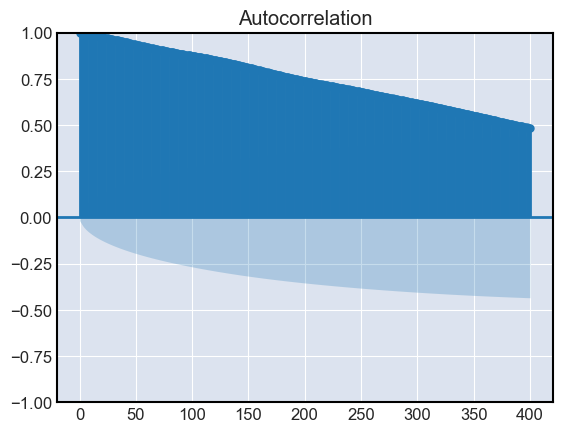

In [ ]:
import statsmodels.api as sm

x = sm.graphics.tsa.plot_acf(df['close'], lags=400) # 400日分のデータを利用して自己相関を計算
plt.show()

時間がたつにつれて相関係数が単調に増加していく様子が読み取れる。
季節性はないといってよいだろう。

### 異常値の確認

In [ ]:
mean = df['close'].mean()
std = df['close'].std()
df['zscore'] = (df['close'] - mean) / std

outliers = df[(df['zscore'] > 3) | (df['zscore'] < -3)] # |zscore|が3より大きいものを外れ値とする
outliers

,close,open,high,low,volume,rate,zscore
date,,,,,,,
1987-02-24,270.6,258.8,272.5,257.8,605420000,15.00%,3.536396
1987-02-25,252.9,258.8,262.7,252.0,733930000,-6.54%,3.185569
1987-02-26,247.1,256.9,261.8,243.1,349450000,-2.29%,3.070608
1987-02-27,253.9,250.0,262.7,244.1,347710000,2.75%,3.205389
1987-03-02,263.7,265.7,267.6,259.8,320110000,3.86%,3.399633
...,...,...,...,...,...,...,...
1988-04-28,244.1,240.2,246.1,239.2,238640000,1.62%,3.011146
1988-05-02,246.1,247.1,248.0,246.1,146810000,0.82%,3.050788
1988-06-10,244.1,244.1,246.1,242.2,224550000,1.62%,3.011146


上でも確認した通り,1990年までの株価がほかの年と比べてかなり高いと読み取れる。

## データの標準化

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = df.drop(['open','high', 'low', 'rate', 'zcore'], axis=1)
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.head()

,close,volume
date,,
1987-02-12,1.788304,8.850080
1987-02-13,1.592069,1.995764
1987-02-16,1.651534,1.501283
1987-02-17,1.788304,5.665247
1987-02-18,1.962736,4.974557


上記の通り1990年以前と以降で傾向が異なるため、MinMaxScalerではなくStandardScalerを用いることで外れ値の影響を小さくすることにした。

In [ ]:
df_scaled.to_csv('stock_price_scaled.csv', index=True)

## モデルの選定とトレーニング1

今回は $\\$
①時系列データを扱う $\\$
②季節性などの法則性がない $\\$
ため統計的な手法は困難であると考え、LSTMを利用することとした。

### データの読み込みと整形

In [25]:
df = pd.read_csv('stock_price_scaled.csv', index_col='date', parse_dates=True)
df_train = df.loc['1987':'2023']['close']   # 1987年から2023年までのデータを学習データとする
df_test = df.loc['2024':]['close']          # 2024年以降のデータをテストデータとする

def reshape_data(data, window_size):    # 入力データをLSTMに入力できる形に変換する.window_sizeは過去何日分のデータを見るかを指定
    x = []
    y = data[window_size:]
    for i in range(len(data) - window_size):
        x.append(data[i:(i + window_size)]) # i日目からi+window_size日目までのデータをxに格納
    return np.array(x), y

### モデルの作成と学習

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

num_middle_layers1 = 100    # 隠れ層のニューロン数
length_of_sequences = 30    # 過去10日分のデータを使用

train_x, train_y = reshape_data(df_train.values, length_of_sequences)
test_x, test_y = reshape_data(df_test.values, length_of_sequences)

model = Sequential()
model.add(LSTM(num_middle_layers1, input_shape=(length_of_sequences, 1), return_sequences=False))   # LSTM層
model.add(Dense(1))
model.add(Activation("linear"))   # num_middle_layerから出力への全結合層
model.compile(loss="mean_squared_error", optimizer="adam")  # 損失関数：平均二乗誤差/最適化手法:Adamを設定
model.fit(train_x, train_y, batch_size=100, epochs=50, validation_split=0.2)    # 20%のデータを検証用に使用し,50エポックで学習.

Epoch 1/50


c:\Users\nabem\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1801 - val_loss: 0.0026
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_l

### 予想の図示とモデルの評価

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 
loss: 0.001747281407006085


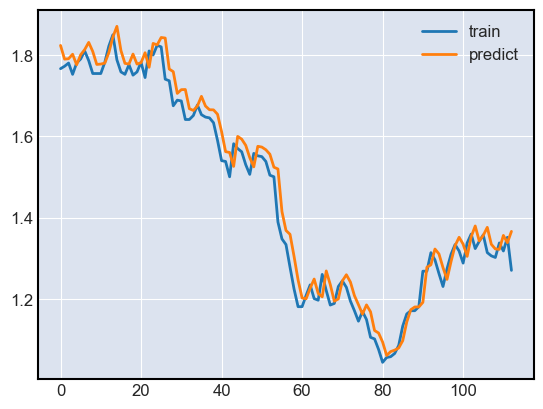

In [34]:
pre = model.predict(test_x)   # テストデータを用いて予測
plt.figure()
plt.plot(test_y, label='train')  # テストデータの実測値
plt.plot(pre, label='predict')   # テストデータの予測値
plt.legend()

loss = model.evaluate(test_x, test_y)   # テストデータに対する損失を計算
print('loss:', loss)

回帰問題であるため,評価値としては単純で理解しやすい指標として平均二乗誤差を用いた.
結果としては

訓練データ:0.0019, 検証用データ:0.0009, テストデータ:0.0017

となった.そこまで過学習はせず,そこそこの性能であるといえる.
しかしグラフを見てみると予想値が右に一日分ずれているだけであり,正しく「予想」しているといえるのかは微妙な問題である.
そこで改善点としては以下の3点があげられる.

①volumeの値を利用する

今回の学習では終値のみを用いた学習を行ったが,そこに出来高を追加したうえで学習を行う.
上のグラフだけでは終値と出来高の関連を読み取ることは難しかったが,ニューラルネットワークによってそれが可能になると考えた.

②ニューラルネットワークの構成をもう少し複雑にする

今回はLSTM層と全結合層のみで構成したが,今回のような予想が困難な場合はよりネットワークを複雑にすることで精度が上がると考えられる.

③1990年以降のデータのみを学習に用いる

データの分析で述べた通り,1990年以前はそれ以降と比較して株価の傾向が異なる.したがって1990年以前のデータを省くことで,
より汎化性能が高くなる可能性がある.

### モデルの作成と評価2

In [35]:
df = pd.read_csv('stock_price_scaled.csv', index_col='date', parse_dates=True)
df_train = df.loc['1990':'2023'][['close', 'volume']]   # 1990年から2023年までのcloseとvolumeのデータを学習データとする
df_test = df.loc['2024'][['close', 'volume']]

def reshape_data(data, window_size):
    x = []
    y = data[window_size:,:]
    for i in range(int(len(data)) - window_size):
        x.append(data[i:(i + window_size), :])
    return np.array(x), np.array(y)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

num_middle_layers1 = 200
num_middle_layers2 = 100
length_of_sequences = 15

train_x, train_y = reshape_data(df_train.values, length_of_sequences)
test_x, test_y = reshape_data(df_test.values, length_of_sequences)
# データの形状は(データ数, 過去の日数=length_of_sequences, 特徴量の数=2)となる

model = Sequential()
model.add(LSTM(num_middle_layers1, input_shape=(length_of_sequences, 2), return_sequences=False))   # LSTM層
model.add(Activation("relu"))   # 活性化関数:ReLU
model.add(Dropout(0.2))         # ドロップアウト:0.2
model.add(Dense(num_middle_layers2))    # num_middle_layers2の全結合層
model.add(Activation("relu"))   # 活性化関数:ReLU
model.add(Dropout(0.3))         # ドロップアウト:0.3
model.add(Dense(1))             # 出力層
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(train_x, train_y[:,0], batch_size=100, epochs=20, validation_split=0.2)   # train_yについてはcloseのみを使用

Epoch 1/20


c:\Users\nabem\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.1417 - val_loss: 0.0093
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0139 - val_loss: 0.0157
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0118 - val_loss: 0.0069
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0106 - val_loss: 0.0027
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0094 - val_loss: 0.0063
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0096 - val_loss: 0.0037
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0093 - val_loss: 0.0059
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0096 - val_loss: 0.0049
Epoch 9/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0090 - val_loss: 0.0084
Epoch 10/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0083 - val_loss: 0.0052
Epoch 11/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0083 - val_loss: 0.0017
Epoch 12/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0079 - val_l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 
loss: 0.0017289873212575912


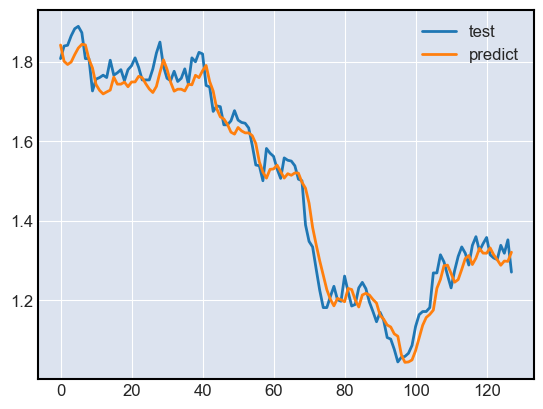

In [ ]:
pre = model.predict(test_x)
plt.figure()
plt.plot(test_y[:, 0], label='test')
plt.plot(pre[:, 0], label='predict')
plt.legend()

loss = model.evaluate(test_x, test_y[:,0])
print('loss:', loss)

## 以下仮説の検証

In [2]:
df = pd.read_csv('stock_price_scaled.csv', index_col='date', parse_dates=True)
df_train = df.loc['1987':'2023']['close']   # 1987年から2023年までのデータを学習データとする
df_test = df.loc['2024':]['close']          # 2024年以降のデータをテストデータとする

def reshape_data(data, window_size):    # 入力データをLSTMに入力できる形に変換する.window_sizeは過去何日分のデータを見るかを指定
    x = []
    y = data[window_size:]
    for i in range(len(data) - window_size):
        x.append(data[i:(i + window_size)]) # i日目からi+window_size日目までのデータをxに格納
    return np.array(x), y

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

num_middle_layers1 = 100    # 隠れ層のニューロン数
length_of_sequences = 30    # 過去10日分のデータを使用

train_x, train_y = reshape_data(df_train.values, length_of_sequences)
test_x, test_y = reshape_data(df_test.values, length_of_sequences)

model = Sequential()
model.add(LSTM(num_middle_layers1, input_shape=(length_of_sequences, 1), return_sequences=False))   # LSTM層
model.add(Activation("relu"))   # 活性化関数:ReLU
model.add(Dropout(0.2))         # ドロップアウト:0.2
model.add(Dense(100))
model.add(Activation("relu"))   # 活性化関数:ReLU
model.add(Dropout(0.3))         # ドロップアウト:0.3
model.add(Dense(1))
model.add(Activation("linear"))   # num_middle_layerから出力への全結合層
model.compile(loss="mean_squared_error", optimizer="adam")  # 損失関数：平均二乗誤差/最適化手法:Adamを設定
model.fit(train_x, train_y, batch_size=100, epochs=50, validation_split=0.2)    # 20%のデータを検証用に使用し,50エポックで学習.

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.3526 - val_loss: 0.0042
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0314 - val_loss: 0.0025
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0245 - val_loss: 0.0020
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0230 - val_loss: 0.0039
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0227 - val_loss: 0.0027
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0230 - val_loss: 0.0034
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0180 - val_loss: 0.0024
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0202 - val_loss: 0.0015
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0173 - val_loss: 0.0015
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0186 - val_loss: 0.0014
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0164 - val_loss: 0.0015
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 
loss: 0.002714512636885047


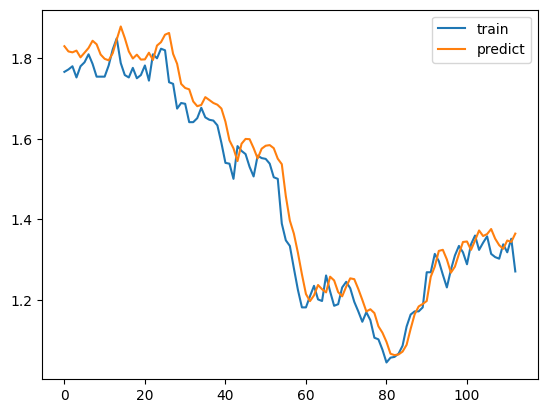

In [5]:
pre = model.predict(test_x)   # テストデータを用いて予測
plt.figure()
plt.plot(test_y, label='train')  # テストデータの実測値
plt.plot(pre, label='predict')   # テストデータの予測値
plt.legend()

loss = model.evaluate(test_x, test_y)   # テストデータに対する損失を計算
print('loss:', loss)

In [6]:
df = pd.read_csv('stock_price_scaled.csv', index_col='date', parse_dates=True)
df_train = df.loc['1990':'2023'][['close', 'volume']]   # 1990年から2023年までのcloseとvolumeのデータを学習データとする
df_test = df.loc['2024'][['close', 'volume']]

def reshape_data(data, window_size):
    x = []
    y = data[window_size:,:]
    for i in range(int(len(data)) - window_size):
        x.append(data[i:(i + window_size), :])
    return np.array(x), np.array(y)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

num_middle_layers1 = 200
# num_middle_layers2 = 100
length_of_sequences = 30

train_x, train_y = reshape_data(df_train.values, length_of_sequences)
test_x, test_y = reshape_data(df_test.values, length_of_sequences)
# データの形状は(データ数, 過去の日数=length_of_sequences, 特徴量の数=2)となる

model = Sequential()
model.add(LSTM(num_middle_layers1, input_shape=(length_of_sequences, 2), return_sequences=False))   # LSTM層
model.add(Dense(1))             # 出力層
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(train_x, train_y[:,0], batch_size=100, epochs=50, validation_split=0.2)   # train_yについてはcloseのみを使用

Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0895 - val_loss: 0.0039
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0034 - val_loss: 0.0050
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.0035
loss: 0.003048838349059224


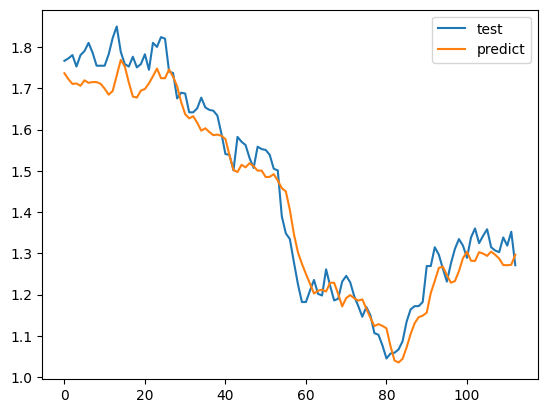

In [8]:
pre = model.predict(test_x)
plt.figure()
plt.plot(test_y[:, 0], label='test')
plt.plot(pre[:, 0], label='predict')
plt.legend()

loss = model.evaluate(test_x, test_y[:,0])
print('loss:', loss)